# Single atom training
This notebook goes through the workflow of setting the hyperparameters, collecting atom manipulation data, and training the deep reinforcement learning agent.

### Importing modules

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from matplotlib import pyplot as plt
import matplotlib
import cv2
import numpy as np
import pandas as pd
from collections import deque, namedtuple
from matplotlib import pyplot as plt, patches
import torch
from REACTRL import RealExpEnv, Episode_Memory, Createc_Controller, sac_agent, ReplayMemory, HerReplayMemory
from REACTRL import plot_graph, show_reset, show_done, show_step, image_detect_edges
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
from matplotlib import pyplot as plt, patches

# Python code to demonstrate namedtuple()
from collections import namedtuple

import pickle

cpu


### Setting the anchor image
This cell retrieves the current STM scan image and use it as the template for positioning the anchor in STM images

succeed to connect


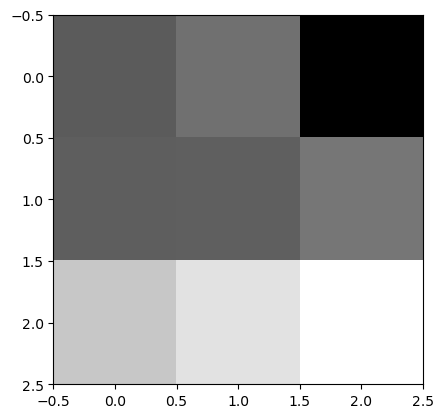

In [2]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
#TODO
#Set the pixel of the top-left corner, widht, and height of the anchor
#If the anchor is not used, just set w and h to a small number like below
top_left, w, h = (0,0), 3, 3
#template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
#plt.imshow(template)

template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)

### Set the parameters and create a RealExpEnv object

In [3]:
#TODO
step_nm = 0.4 #Set the radius of the manipulation start position relative the the atom start position
goal_nm  = 2 #Set the radius of the manipulation end position relative the the atom start position
max_mvolt = 15 #Set the maximum bias voltage in mV 
max_pcurrent_to_mvolt_ratio = 6E3 #Set the maximum conductance in pA/mV
max_len = 5 #Set maximum episode length
template_max_y = 3 #Set the maximum or minimum row number to search for anchor
#Set the path to load CNN weight for the atom movement classifier
CNN_weight_path = 'C:/LocalUserData/User-data/phys-asp-lab/nian_auto_spm/reaction_rl/training_data_and_model_parameters/model parameters/_atom_move_detector_conv_2460.pth'
current_jump  = 4 #Set the current jump gradient/ std(current) threshold required to take STM scan

#Set STM scan parameters
pixel = 128
im_size_nm = 10 #Image size in nm 
scan_mV = 1000 #bias voltage
scan_speed_l_m_s = 600 
x_nm, y_nm = createc_controller.get_offset_nm()
offset_nm = np.array([x_nm, y_nm]) #Set offset to current offset value

#Set manipulation parameters to pull atoms from image edge to center
pull_back_mV = 5 #bias in mV
pull_back_pA = 60000 #current in pA

#Set manipulation limit [left, right, up, down] in nm
manip_limit_nm = np.array([x_nm - 0.5*im_size_nm+0.25, x_nm + 0.5*im_size_nm-0.25, y_nm+0.25, y_nm+im_size_nm-0.25])

env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, scan_mV, max_len, 
                 CNN_weight_path, 
                 bottom=False, random_scan_rate = 0.8, pull_back_mV = pull_back_mV,
                 pull_back_pA = pull_back_pA)

succeed to connect
Load cnn weight


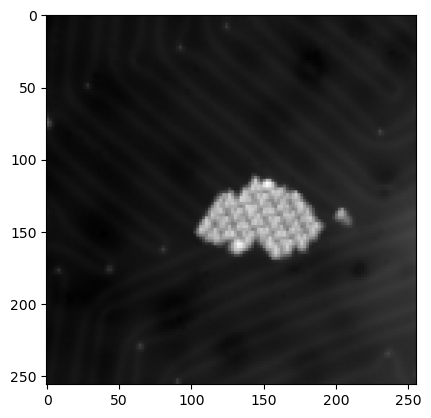

In [6]:
plt.imshow(img2)

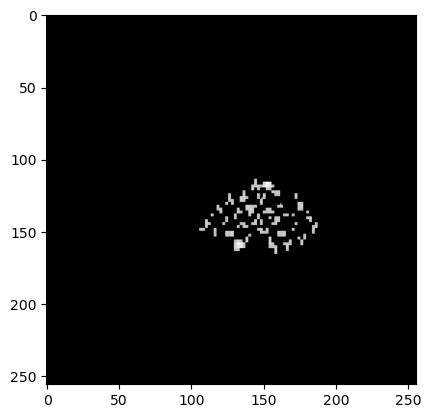

In [4]:
img=cv2.imread('selected_regions.jpeg')

img2=cv2.imread('selected_regions.jpeg')
# plt.imshow(img, extent=[x_nm-len_nm/2, x_nm+len_nm/2, y_nm, y_nm+len_nm])
img[img<190]=0
plt.imshow(img)
# plt.imshow(img,extent=[x_nm-len_nm/2, x_nm+len_nm/2, y_nm+len_nm, y_nm])
# plt.scatter([147], [141])

In [5]:
data ={'x': np.where(img>190)[1], 'y': np.where(img>190)[0]}
data=pd.DataFrame(data)
data=data.drop_duplicates(ignore_index=True)
data.loc[:, 'dist']=np.sqrt((data.x-147)**2+(data.y-141)**2)
data=data.sort_values(by='dist', ascending=False, ignore_index=True)

In [6]:
data

,x,y,dist
0,106,149,41.773197
1,106,148,41.593269
2,107,149,40.792156
3,107,148,40.607881
4,187,147,40.447497
...,...,...,...
649,147,139,2.000000
650,146,140,1.414214
651,147,140,1.000000
652,146,141,1.000000


In [29]:
x

-63.8005625

In [30]:
env.createc_controller.offset_nm 

-122.62975

In [32]:
env.createc_controller.offset_nm 

array([ -63.8005625, -127.62975  ])

In [33]:
env.createc_controller.im_size_nm

10

The scan will take 42.6 seconds
offset_test0000 [ -48.5661875 -127.239125 ]
offset_test1111 [ -48.5661875 -127.239125 ]


KeyboardInterrupt: 

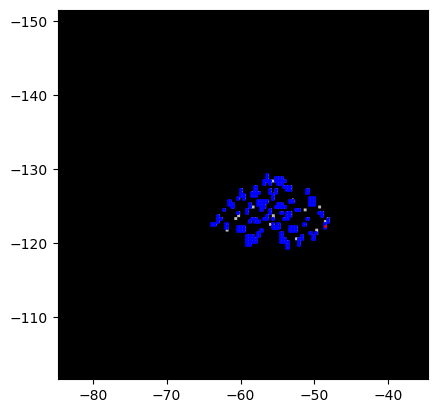

In [8]:
ref_x=147
ref_y=141
x_nm=-59.699
y_nm=-151.536
len_nm=50  # nm
init_len=1 # nm
move_len=5 # nm
check_points=[[data['x'][i], data['y'][i]] for i in range(len(data))]
check_points_full=[[data['x'][i], data['y'][i]] for i in range(len(data))]
scan_nm_small=10

move_points=[]
plt.imshow(img, extent=[x_nm-len_nm/2, x_nm+len_nm/2, y_nm+len_nm, y_nm])
plt.scatter(x_nm-len_nm/2+len_nm/256*data['x'], y_nm+len_nm/256*data['y'], s=1, c='b')
data_move_all=[]
tip_form_x=133
tip_form_y=-117
tip_len=120
tip_points=[]
tip_points.append([tip_form_x, tip_form_y])
tip_lat_all=[]
# for i in range(len(data)):
for i in range(13, len(data), 5):
# for i in range(3):
    x=x_nm-len_nm/2+len_nm/256*data['x'][i]
    y=y_nm+len_nm/256*data['y'][i]
    plt.scatter([x], [y], s=1, c='r')

    check_points.remove([data['x'][i], data['y'][i]])
    for epoch in range(5):
        tip_start_x=x+init_len*(np.random.rand()*2-1)
        tip_start_y=y+init_len*(np.random.rand()*2-1)
        tip_end_x=tip_start_x+move_len*(np.random.rand()*2-1)
        tip_end_y=tip_start_y+move_len*(np.random.rand()*2-1)
        check_points_array=np.array(check_points)

        for find_epoch in range(50):
            if np.sqrt((check_points_array[:, 0]-tip_end_x)**2+(check_points_array[:, 1]-tip_end_y)**2).min()<2 or np.sqrt((tip_start_x-tip_end_x)**2-(tip_start_y-tip_end_y)**2)<1.5  or np.sqrt((x-tip_end_x)**2+(y-tip_end_y)**2)>scan_nm_small/2:
                tip_end_x=tip_start_x+move_len*(np.random.rand()*2-1)
                tip_end_y=tip_start_y+move_len*(np.random.rand()*2-1)
            else:
                if find_epoch==49:
                    break
                else:
                    pass    

        env.createc_controller.offset_nm = np.array([x, y-scan_nm_small/2])
        env.createc_controller.im_size_nm= scan_nm_small
        scan_data=env.createc_controller.scan_image()
        plt.imsave('images_move_before/image_forward_%s_%s.png' % (i, epoch), scan_data[0])
        plt.imsave('images_move_before/image_backward_%s_%s.png' % (i, epoch), scan_data[1])
        plt.imsave('images_move_before/image_for_back_%s_%s.png' % (i, epoch), (scan_data[0]+scan_data[1])/2)

        check_points.append([tip_end_x, tip_end_y])
        check_points_full.append([tip_end_x, tip_end_y])
        move_points.append([tip_end_x, tip_end_y])
        plt.scatter([tip_start_x], [tip_start_y], s=1, c='r')
        print(x, y-scan_nm_small/2, tip_start_x, tip_start_y, tip_end_x, tip_end_x)
        data_move=env.createc_controller.lat_manipulation(tip_start_x, tip_start_y, tip_end_x, tip_end_y, 32, 1000, np.array([x, y-scan_nm_small/2]), scan_nm_small)
        tip_lat_all.append([i, epoch, tip_start_x, tip_start_y, tip_end_x, tip_end_y])
        data_move_all.append(data_move)
        env.createc_controller.offset_nm = np.array([x, y-scan_nm_small/2])
        env.createc_controller.im_size_nm= scan_nm_small
        scan_data=env.createc_controller.scan_image()
        plt.imsave('images_move_after/image_forward_%s_%s.png' % (i, epoch), scan_data[0])
        plt.imsave('images_move_after/image_backward_%s_%s.png' % (i, epoch), scan_data[1])
        plt.imsave('images_move_after/image_for_back_%s_%s.png' % (i, epoch), (scan_data[0]+scan_data[1])/2)
    

        if epoch==2:
            for j in range(2):
                tip_x=tip_form_x+120*np.random.rand()
                tip_y=tip_form_y+120*np.random.rand()
                check_tip_points_array=np.array(tip_points)
                while np.sqrt((check_tip_points_array[:, 0]-tip_x)**2+(check_tip_points_array[:, 1]-tip_y)**2).min()<3.5:
                    tip_x=tip_form_x+120*np.random.rand()
                    tip_y=tip_form_y+120*np.random.rand()
                up_limit=35
                down_limit=10
                tip_z_approach=down_limit+np.random.rand()*(up_limit-down_limit)
                env.createc_controller.tip_form(tip_z_approach, tip_x, tip_y)  
                tip_points.append([tip_x, tip_y])

    check_points.append([data['x'][i], data['y'][i]])  # restore all points in data plus tip_end_points

with open("data_move_1004.pkl", "wb") as fp:   #Pickling
    pickle.dump(data_move_all, fp)
plt.xlim(x_nm-len_nm/2, x_nm+len_nm/2)
plt.ylim(y_nm, y_nm+len_nm)
        
        

In [26]:
data

,x,y,dist
0,106,149,41.773197
1,106,148,41.593269
2,107,149,40.792156
3,107,148,40.607881
4,187,147,40.447497
...,...,...,...
649,147,139,2.000000
650,146,140,1.414214
651,147,140,1.000000
652,146,141,1.000000


In [18]:
data.x

((-0.12421033531427383,),
 (-0.12491607666015625,),
 (-0.12562181055545807,),
 (-0.1270332932472229,),
 (-0.1277390420436859,),
 (-0.12915052473545074,),
 (-0.12985625863075256,),
 (-0.13056199252605438,),
 (-0.1319734752178192,),
 (-0.13267922401428223,),
 (-0.13409070670604706,),
 (-0.13479644060134888,),
 (-0.1355021893978119,),
 (-0.13691365718841553,),
 (-0.13761940598487854,),
 (-0.13903088867664337,),
 (-0.1397366225719452,),
 (-0.1404423713684082,),
 (-0.14185385406017303,),
 (-0.14255958795547485,),
 (-0.14397107064723969,),
 (-0.1446768045425415,),
 (-0.14538255333900452,),
 (-0.14679403603076935,),
 (-0.14749976992607117,),
 (-0.148911252617836,),
 (-0.14961698651313782,),
 (-0.15032273530960083,),
 (-0.15173421800136566,),
 (-0.15243995189666748,),
 (-0.1538514345884323,),
 (-0.15455718338489532,),
 (-0.15526291728019714,),
 (-0.15667439997196198,),
 (-0.1573801338672638,),
 (-0.15879161655902863,),
 (-0.15949736535549164,),
 (-0.16020309925079346,),
 (-0.1616145819425583,)

In [22]:
data

,x,y,dist
0,106,149,41.773197
1,106,148,41.593269
2,107,149,40.792156
3,107,148,40.607881
4,187,147,40.447497
...,...,...,...
649,147,139,2.000000
650,146,140,1.414214
651,147,140,1.000000
652,146,141,1.000000


In [20]:
data_move_all[i].time

((0.0,),
 (0.0024999999441206455,),
 (0.004999999888241291,),
 (0.007499999832361937,),
 (0.009999999776482582,),
 (0.012500000186264515,),
 (0.014999999664723873,),
 (0.017500000074505806,),
 (0.019999999552965164,),
 (0.02250000089406967,),
 (0.02500000037252903,),
 (0.027499999850988388,),
 (0.029999999329447746,),
 (0.032499998807907104,),
 (0.03500000014901161,),
 (0.03750000149011612,),
 (0.03999999910593033,),
 (0.042500000447034836,),
 (0.04500000178813934,),
 (0.04749999940395355,),
 (0.05000000074505806,),
 (0.05249999836087227,),
 (0.054999999701976776,),
 (0.057500001043081284,),
 (0.05999999865889549,),
 (0.0625,),
 (0.06499999761581421,),
 (0.06750000268220901,),
 (0.07000000029802322,),
 (0.07249999791383743,),
 (0.07500000298023224,),
 (0.07750000059604645,),
 (0.07999999821186066,),
 (0.08250000327825546,),
 (0.08500000089406967,),
 (0.08749999850988388,),
 (0.09000000357627869,),
 (0.0925000011920929,),
 (0.0949999988079071,),
 (0.09749999642372131,),
 (0.100000001490

In [ ]:
plt.imshow(data_move_all[i].time, data_move_all[i].current)

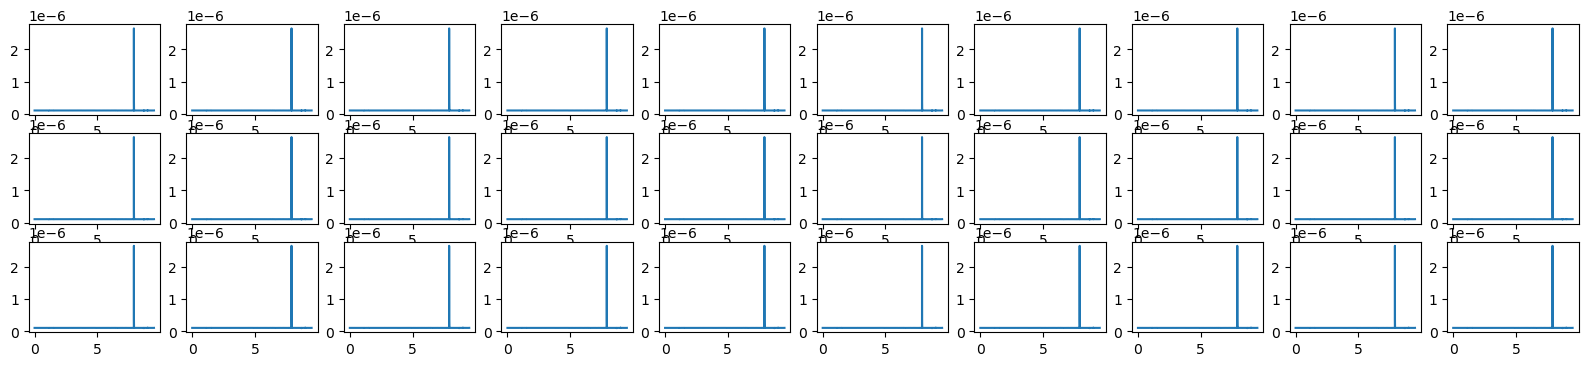

In [21]:
plt.figure(figsize=(20, 4))
for k in range(30):
    plt.subplot(3, 10, k+1)
    plt.plot(data_move_all[i].time, data_move_all[i].current)


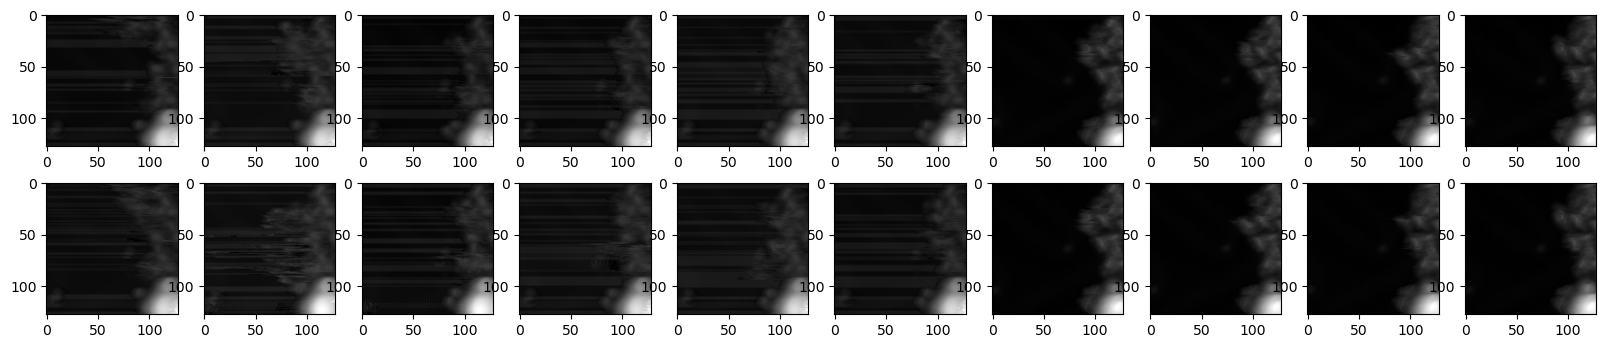

In [16]:
plt.figure(figsize=(20, 4))
for k in range(10):
    plt.subplot(2, 10, k+1)
    img_before=cv2.imread('images_move_before/image_for_back_%s_%s.png' % (2, k))
    plt.imshow(img_before)
    plt.subplot(2, 10, k+11)
    img_after=cv2.imread('images_move_after/image_for_back_%s_%s.png' % (2, k))
    plt.imshow(img_after)

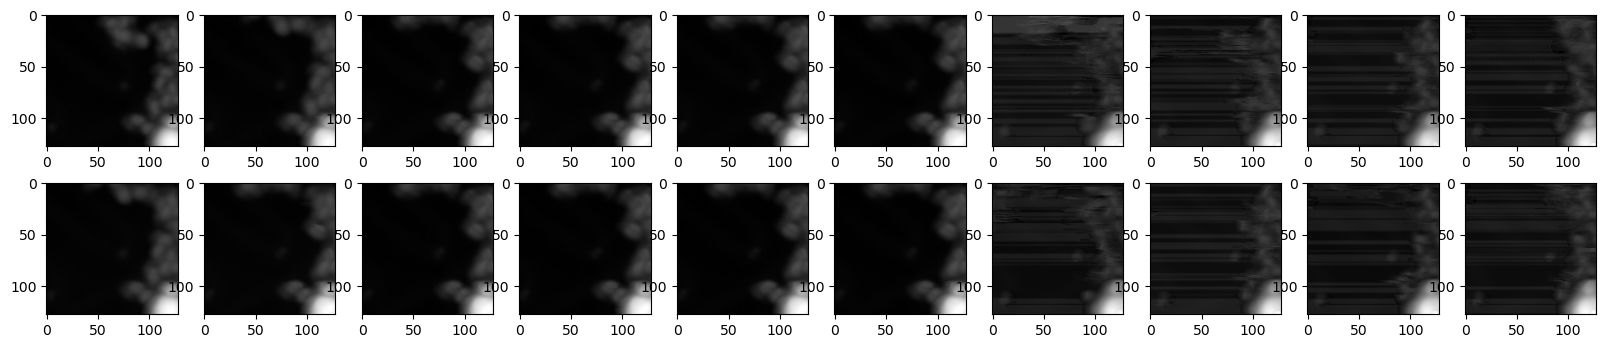

In [15]:
plt.figure(figsize=(20, 4))
for k in range(10):
    plt.subplot(2, 10, k+1)
    img_before=cv2.imread('images_move_before/image_for_back_%s_%s.png' % (1, k))
    plt.imshow(img_before)
    plt.subplot(2, 10, k+11)
    img_after=cv2.imread('images_move_after/image_for_back_%s_%s.png' % (1, k))
    plt.imshow(img_after)

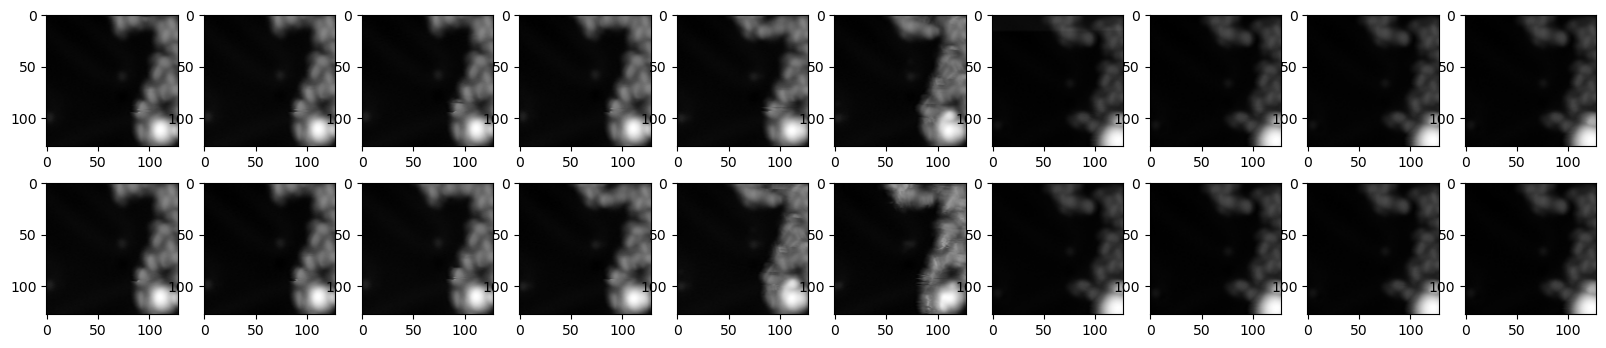

In [14]:
plt.figure(figsize=(20, 4))
for k in range(10):
    plt.subplot(2, 10, k+1)
    img_before=cv2.imread('images_move_before/image_for_back_%s_%s.png' % (0, k))
    plt.imshow(img_before)
    plt.subplot(2, 10, k+11)
    img_after=cv2.imread('images_move_after/image_for_back_%s_%s.png' % (0, k))
    plt.imshow(img_after)
    

In [9]:
 check_points_full

[[106, 149],
 [106, 148],
 [107, 149],
 [107, 148],
 [187, 147],
 [187, 146],
 [187, 144],
 [108, 149],
 [108, 148],
 [186, 147],
 [186, 146],
 [185, 151],
 [186, 145],
 [185, 150],
 [109, 149],
 [185, 149],
 [109, 148],
 [185, 148],
 [184, 151],
 [184, 150],
 [184, 149],
 [184, 148],
 [110, 147],
 [110, 146],
 [110, 145],
 [110, 144],
 [110, 143],
 [110, 142],
 [111, 147],
 [111, 146],
 [111, 145],
 [111, 144],
 [183, 143],
 [111, 143],
 [183, 142],
 [111, 142],
 [183, 140],
 [183, 141],
 [112, 145],
 [112, 144],
 [182, 143],
 [182, 140],
 [182, 142],
 [182, 141],
 [177, 159],
 [179, 155],
 [179, 154],
 [177, 158],
 [113, 145],
 [176, 159],
 [113, 144],
 [181, 140],
 [178, 155],
 [177, 157],
 [181, 141],
 [178, 154],
 [176, 158],
 [177, 156],
 [114, 138],
 [176, 157],
 [114, 139],
 [180, 140],
 [180, 141],
 [176, 156],
 [116, 151],
 [116, 150],
 [115, 138],
 [115, 139],
 [116, 149],
 [177, 130],
 [116, 148],
 [177, 131],
 [117, 151],
 [177, 132],
 [117, 150],
 [175, 155],
 [173, 124],

In [7]:
print(tip_start_x, tip_start_y, tip_end_x, tip_end_x)

-62.44053804460576 -121.98829695491509 -57.76962483954707 -57.76962483954707


In [7]:
env.createc_controller.offset_nm = offset_nm
env.createc_controller.im_size_nm= im_size_nm
scan_data=env.createc_controller.scan_image()

The scan will take 101.6 seconds
offset_test0000 [ -58.95823479 -147.93648529]
offset_test1111 [ -58.95823479 -147.93648529]
offset_test2222 [ -58.95823479 -147.93648529]


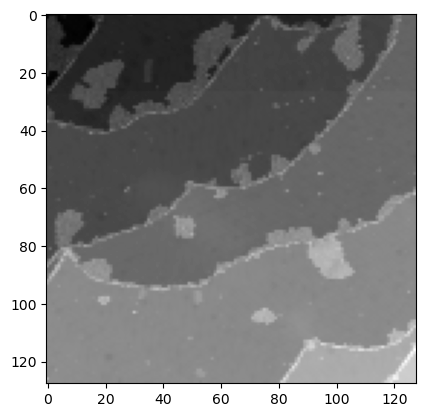

In [44]:
img=scan_data[0]
plt.imshow(img)
plt.imsave('large_image.png', img)

In [45]:
img=cv2.imread('large_image.png') 

In [47]:

edges=image_detect_edges(img)

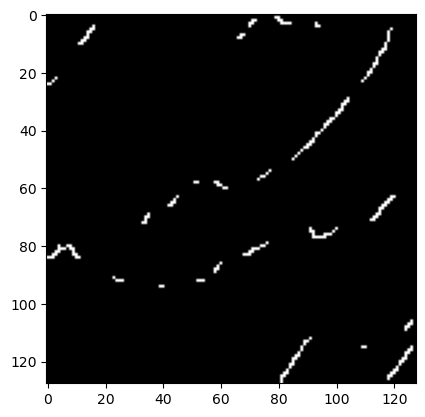

In [48]:
plt.imshow(edges)

In [57]:
edges.shape

(128, 128)

In [49]:
edges_points=np.where(edges==255)

In [95]:
edges_points=np.where(edges>0)

In [97]:
edges_points[1].shape

(242,)

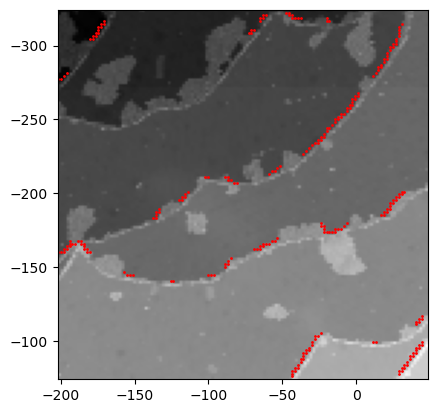

In [62]:
for i in range(len(edges_points[0])):
    # plt.imshow(edges, extent=[x_nm-250/2, x_nm+250/2, y_nm+250, y_nm])
    plt.imshow(img, extent=[x_nm-250/2, x_nm+250/2, y_nm+250, y_nm])
    plt.scatter(x_nm-250/2+edges_points[1][i]*250/128, y_nm+edges_points[0][i]*250/128, s=1, c='r')

    
    # for j in range(5):
        # plt.subplot(5,5,i*5+j+1)
        # left, right, up, down = data_all[i+j][2][0]-50, data_all[i+j][2][0]+50, data_all[i+j][2][1]-50, data_all[i+j][2][1]+50)
        # plt.imshow(data_all[i+j][0], extent=[-50,50,-50,50]))  

In [83]:
a = np.array([1,2,3,4,5,6,7,8,9,10])
b = np.array([1,2,3,4,5,6,7,8,9,10])
np.savez('test.npz', a, b)

In [68]:
data_scan_128

[(array([[-6.14542866, -6.13569212, -6.14894962, ..., -6.39232254,
          -6.39363861, -6.40080261],
         [-6.13913202, -6.13180637, -6.1489563 , ..., -6.39777517,
          -6.3957243 , -6.39801025],
         [-6.13384771, -6.12463856, -6.13727474, ..., -6.40033484,
          -6.39904213, -6.40211773],
         ...,
         [-6.14227915, -6.14118958, -6.14628029, ..., -6.14309788,
          -6.1428175 , -6.14342976],
         [-6.13989019, -6.1438942 , -6.1454196 , ..., -6.14394283,
          -6.14338446, -6.14706087],
         [-6.13793564, -6.14300394, -6.14263344, ..., -6.14353991,
          -6.14365911, -6.14923382]]),
  array([[-6.18009281, -6.1867218 , -6.18279791, ..., -6.3962822 ,
          -6.40011883, -6.40550041],
         [-6.16253996, -6.16275263, -6.15546274, ..., -6.39260054,
          -6.39649534, -6.40114117],
         [-6.14707994, -6.15063286, -6.13907385, ..., -6.39087534,
          -6.39391232, -6.39616299],
         ...,
         [-6.1449132 , -6.14234972

In [85]:
import pickle
with open("test.pkl", "wb") as fp:   #Pickling
    pickle.dump(data_scan_128, fp)

In [86]:
pickle.load(open("test", "rb"))

[(array([[-6.05398941, -6.06157255, -6.06901455, ..., -6.38174677,
          -6.38653851, -6.38394594],
         [-6.05436993, -6.05194521, -6.05482101, ..., -6.38637733,
          -6.38117313, -6.37956476],
         [-6.03406   , -6.02614117, -6.02831745, ..., -6.38737345,
          -6.38171816, -6.38291121],
         ...,
         [-6.14034128, -6.140028  , -6.14041853, ..., -6.14599323,
          -6.14479733, -6.13884544],
         [-6.13906717, -6.14325905, -6.14463568, ..., -6.13815498,
          -6.13977671, -6.14172459],
         [-6.13620472, -6.13986397, -6.14719915, ..., -6.14027977,
          -6.13934851, -6.15036869]]),
  array([[-6.05836153, -6.07220602, -6.09454346, ..., -6.3856616 ,
          -6.38449764, -6.38669014],
         [-6.04471636, -6.05321264, -6.07784224, ..., -6.38006449,
          -6.38038349, -6.37847185],
         [-6.03034878, -6.04224634, -6.06895971, ..., -6.38107634,
          -6.38185692, -6.38605165],
         ...,
         [-6.13993502, -6.13876152

In [98]:
data_scan_128=[]
for i in range(len(edges_points[0])):
# for i in range(3): # test
    # plt.imshow(edges, extent=[x_nm-250/2, x_nm+250/2, y_nm+250, y_nm])
    # plt.imshow(img, extent=[x_nm-250/2, x_nm+250/2, y_nm+250, y_nm])
    # plt.scatter(x_nm-250/2+edges_points[1][i]*250/128, y_nm+edges_points[0][i]*250/128, s=1, c='r')       
    env.createc_controller.offset_nm = np.array([x_nm-250/2+edges_points[1][i]*250/128, y_nm+edges_points[0][i]*250/128])
    env.createc_controller.im_size_nm= 8
    scan_data=env.createc_controller.scan_image()
    plt.imsave('images_8_nm/image_8_forward_%s.png' % i, scan_data[0])
    plt.imsave('images_8_nm/image_8_backward_%s.png' % i, scan_data[1])
    plt.imsave('images_8_nm/image_8_for_back_%s.png' % i, (scan_data[0]+scan_data[1])/2)
    data_scan_128.append(scan_data)

with open("data_scan_128.pkl", "wb") as fp:   #Pickling
    pickle.dump(data_scan_128, fp)

The scan will take 34.1 seconds
offset_test0000 [ -47.50878143 -322.3079567 ]
offset_test1111 [ -47.50878143 -322.3079567 ]
offset_test2222 [ -47.50878143 -322.3079567 ]
The scan will take 34.1 seconds
offset_test0000 [ -45.55565643 -322.3079567 ]
offset_test1111 [ -45.55565643 -322.3079567 ]
offset_test2222 [ -45.55565643 -322.3079567 ]
The scan will take 34.1 seconds
offset_test0000 [ -63.13378143 -320.3548317 ]
offset_test1111 [ -63.13378143 -320.3548317 ]
offset_test2222 [ -63.13378143 -320.3548317 ]
The scan will take 34.1 seconds
offset_test0000 [ -61.18065643 -320.3548317 ]
offset_test1111 [ -61.18065643 -320.3548317 ]
offset_test2222 [ -61.18065643 -320.3548317 ]
The scan will take 34.1 seconds
offset_test0000 [ -45.55565643 -320.3548317 ]
offset_test1111 [ -45.55565643 -320.3548317 ]
offset_test2222 [ -45.55565643 -320.3548317 ]
The scan will take 34.1 seconds
offset_test0000 [ -43.60253143 -320.3548317 ]
offset_test1111 [ -43.60253143 -320.3548317 ]
offset_test2222 [ -43.6025

In [105]:
data_scan_128[i][2][1]+data_scan_128[i][3][1]    

-68.2647466955567

In [112]:
print(left, right, bottom, top)

-47.57726143310547 -39.62780143310547 -76.2142066955567 -68.2647466955567


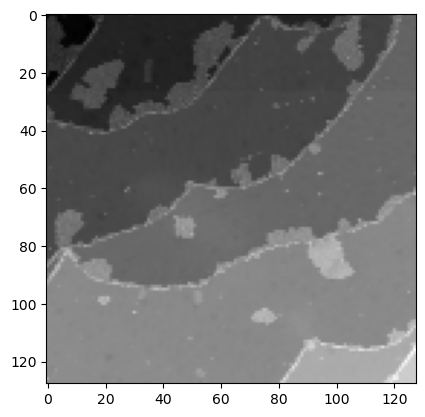

In [113]:
plt.imshow(img)

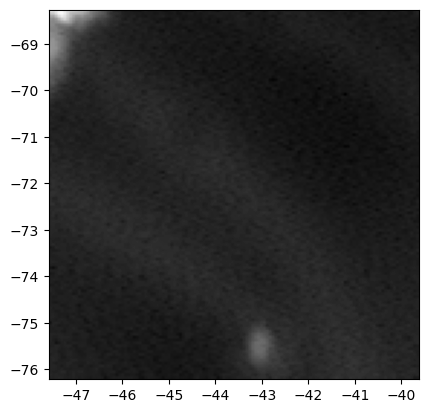

In [123]:
fig = plt.figure()
plt.imshow(img, extent=[x_nm-250/2, x_nm+250/2, y_nm+250, y_nm])
plt.imshow(data_scan_128[i][0], extent=[left,right,bottom,top])



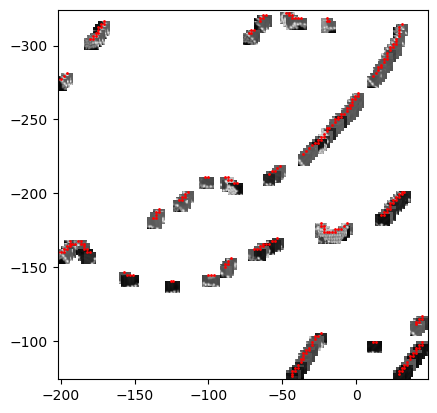

In [127]:
# plt.imshow(edges, extent=[x_nm-250/2, x_nm+250/2, y_nm+250, y_nm])
for i in range(len(edges_points[0])):
# for i in range(3): # test
    # plt.imshow(edges, extent=[x_nm-250/2, x_nm+250/2, y_nm+250, y_nm])
    # plt.imshow(img, extent=[x_nm-250/2, x_nm+250/2, y_nm+250, y_nm])
    # plt.scatter(x_nm-250/2+edges_points[1][i]*250/128, y_nm+edges_points[0][i]*250/128, s=1, c='r')   
    
    plt.scatter(x_nm-250/2+edges_points[1][i]*250/128, y_nm+edges_points[0][i]*250/128, s=1, c='r')
    left=data_scan_128[i][2][0]-data_scan_128[i][3][0]/2
    right=data_scan_128[i][2][0]+data_scan_128[i][3][0]/2 
    bottom=data_scan_128[i][2][1]
    top=data_scan_128[i][2][1]+data_scan_128[i][3][1]    
    plt.imshow(data_scan_128[i][0], extent=[left,right,bottom,top])

plt.xlim(x_nm-250/2, x_nm+250/2)
plt.ylim(y_nm+250, y_nm)
plt.savefig('total.png', dpi=300)

In [90]:
with open("data_scan_128.pkl", "rb") as fp:   # Unpickling
   bbb = pickle.load(fp)


In [94]:
    plt.imsave('images_8_nm/image_8_forward_%s.png' % i, d1[0])
    plt.imsave('images_8_nm/image_8_backward_%s.png' % i, d1[1])
    plt.imsave('images_8_nm/image_8_for_back_%s.png' % i, (d1[0]+d1[1])/2)

In [93]:
d1=bbb[1]

In [55]:
y_nm

-324.2610816955567

In [ ]:
for i in 

In [10]:
im_size_nm

100

In [20]:
data_all[i+j][2]

array([-159.46397781,    3.97066879])

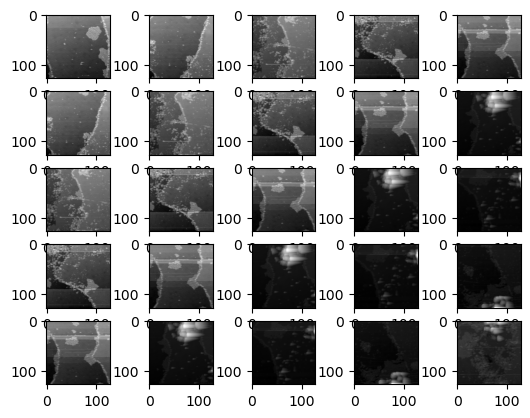

In [8]:
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,i*5+j+1)
        left, right, up, down = data_all[i+j][2][0]-50, data_all[i+j][2][0]+50, data_all[i+j][2][1]-50, data_all[i+j][2][1]+50)
        plt.imshow(data_all[i+j][0], extent=[-50,50,-50,50]))  

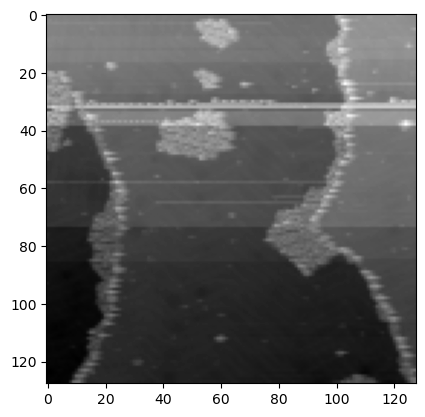

In [11]:
plt.imshow(data_all[4][0])

In [9]:
im_size_nm

100

In [4]:

data_all=[]
data1_all=[]
for i in range(5):
    for j in range(5):
        env.createc_controller.offset_nm = offset_nm+110*np.array([i,j])
        env.createc_controller.im_size_nm= im_size_nm
        scan_data=env.createc_controller.scan_image()
        data_all.append(scan_data)

The scan will take 167.8 seconds
offset_test0000 [-269.46397781 -326.02933121]
offset_test1111 [-269.46397781 -326.02933121]
offset_test2222 [-269.46397781 -326.02933121]
The scan will take 167.8 seconds
offset_test0000 [-269.46397781 -216.02933121]
offset_test1111 [-269.46397781 -216.02933121]
offset_test2222 [-269.46397781 -216.02933121]
The scan will take 167.8 seconds
offset_test0000 [-269.46397781 -106.02933121]
offset_test1111 [-269.46397781 -106.02933121]
offset_test2222 [-269.46397781 -106.02933121]
The scan will take 167.8 seconds
offset_test0000 [-269.46397781    3.97066879]
offset_test1111 [-269.46397781    3.97066879]
offset_test2222 [-269.46397781    3.97066879]
The scan will take 167.8 seconds
offset_test0000 [-269.46397781  113.97066879]
offset_test1111 [-269.46397781  113.97066879]
offset_test2222 [-269.46397781  113.97066879]
The scan will take 167.8 seconds
offset_test0000 [-159.46397781 -326.02933121]
offset_test1111 [-159.46397781 -326.02933121]
offset_test2222 [-15

In [7]:
env.createc_controller.get_offset_nm()

(160.28021621704102, -231.24887084960938)

In [ ]:
env.createc_controller.get_offset_nm()

In [ ]:
env.createc_controller.offset_nm

In [ ]:
173.549       -233.15
175.176       -224.844

# Check vertical manipulation

In [ ]:
data=env.createc_controller.dissassmanipulation(60, 60, 12, 50, 800, np.array([79.99261284, 79.99261284]), 5)

In [ ]:
env.createc_controller.scan_image()

In [ ]:
data=env.createc_controller.dissassmanipulation(165, -223, 16, 100, 800, np.array([171.39860725, -231.26333809]), 10)

In [ ]:
env.createc_controller.ramp_bias_mV(50)
env.createc_controller.set_Z_approach(12)        
env.createc_controller.stm.btn_tipform(40, 40)
env.createc_controller.stm.waitms(50)

In [39]:
from collections import namedtuple
dissociate_data = namedtuple('dissociate_data',['time','V','Z','current_series','dI_dV','topography'])

time = env.createc_controller.stm.vertdata(0, 0)  # time
V= env.createc_controller.stm.vertdata(1,1)  # voltage
Z = env.createc_controller.stm.vertdata(2,4) # Z
current_series = env.createc_controller.stm.vertdata(3,3) # current series
dI_dV = env.createc_controller.stm.vertdata(4,0) # dI/dV
topography = env.createc_controller.stm.vertdata(15,4)
data = dissociate_data(time,V,Z,current_series, dI_dV, topography)

In [ ]:
plt.scatter(data.time, data.current_series)

In [ ]:
# 

In [40]:
env.createc_controller.scan_image()

: 

In [ ]:
env.createc_controller.offset_nm

In [8]:
init_off_x=env.createc_controller.get_offset_nm()[0]
init_off_y=env.createc_controller.get_offset_nm()[1]

tip_init_x=env.createc_controller.get_offset_nm()[0]
tip_init_y=env.createc_controller.get_offset_nm()[1]

length=30



In [8]:
interval= np.array([i for i in range (30)])

In [1]:
np.array([-180, -180])+50

NameError: name 'np' is not defined

In [ ]:
init_offset_nm=np.array([-180, -180])
data_all=[]
data1_all=[]
for i in range(6):
    for j in range(6):
        env.createc_controller.offset_nm = offset_nm
        env.createc_controller.im_size_nm= im_size_nm
        scan_data1=env.createc_controller.scan_image()

In [11]:
data_all=[]
data1_all=[]
for i in range(6):
    for j in range(6):
        # tip_x=tip_init_x-6+i*2
        # tip_y=tip_init_y+j*2
        # data=env.createc_controller.dissassmanipulation(tip_x, tip_y, 25, 1000, 3, np.array([init_off_x, init_off_y]), 3)
        # time = env.createc_controller.stm.vertdata(0, 0)  # time
        # V= env.createc_controller.stm.vertdata(1,1)  # voltage
        # Z = env.createc_controller.stm.vertdata(2,4) # Z
        # current_series = env.createc_controller.stm.vertdata(3,3) # current series
        # dI_dV = env.createc_controller.stm.vertdata(4,0) # dI/dV
        # topography = env.createc_controller.stm.vertdata(15,4)
        # data0 = dissociate_data(time,V,Z,current_series, dI_dV, topography)
        data1 = env.createc_controller.scan_image()
        data_all.append(data0) 
        data1_all.append(data1)

The scan will take 104.9 seconds
offset_test0000 [ 160.28021622 -231.24887085]
offset_test1111 [ 160.28021622 -231.24887085]
offset_test2222 [ 160.28021622 -231.24887085]
The scan will take 104.9 seconds
offset_test0000 [ 160.28021622 -231.24887085]
offset_test1111 [ 160.28021622 -231.24887085]
offset_test2222 [ 160.28021622 -231.24887085]
The scan will take 104.9 seconds
offset_test0000 [ 160.28021622 -231.24887085]
offset_test1111 [ 160.28021622 -231.24887085]
offset_test2222 [ 160.28021622 -231.24887085]
The scan will take 104.9 seconds
offset_test0000 [ 160.28021622 -231.24887085]
offset_test1111 [ 160.28021622 -231.24887085]
offset_test2222 [ 160.28021622 -231.24887085]
The scan will take 104.9 seconds
offset_test0000 [ 160.28021622 -231.24887085]
offset_test1111 [ 160.28021622 -231.24887085]
offset_test2222 [ 160.28021622 -231.24887085]
The scan will take 104.9 seconds
offset_test0000 [ 160.28021622 -231.24887085]
offset_test1111 [ 160.28021622 -231.24887085]
offset_test2222 [ 16

In [34]:
env.createc_controller.im_size_nm

3

In [45]:
env.createc_controller.get_offset_nm()

(-167.66478919982913, -196.3437271118164)

In [52]:
env.createc_controller.get_offset_nm()[0]

-167.64954566955566

In [114]:
offset_nm

array([-177.88882256, -184.61862946])

In [115]:
env.createc_controller.set_Z_approach(15)
# env.createc_controller.offset_nm = np.array([env.createc_controller.get_offset_nm()[0], env.createc_controller.get_offset_nm()[1]])
# env.createc_controller.im_size_nm= env.createc_controller.im_size_nm
# offset_nm = np.array([env.createc_controller.get_offset_nm()[0], env.createc_controller.get_offset_nm()[1]])
# len_nm = env.createc_controller.im_size_nm
args = -177.79, -183.124, None, None, offset_nm, im_size_nm
x_pixel, y_pixel, _, _ = env.createc_controller.nm_to_pixel(*args)
env.createc_controller.stm.setparam('Vpoint2.V', 3500)
env.createc_controller.stm.setparam('VertFBLogiset', 500)
env.createc_controller.stm.btn_tipform(x_pixel, y_pixel)




In [146]:
env.createc_controller.set_Z_approach(15)
# env.createc_controller.offset_nm = np.array([env.createc_controller.get_offset_nm()[0], env.createc_controller.get_offset_nm()[1]])
# env.createc_controller.im_size_nm= env.createc_controller.im_size_nm
# offset_nm = np.array([env.createc_controller.get_offset_nm()[0], env.createc_controller.get_offset_nm()[1]])
# len_nm = env.createc_controller.im_size_nm
args = -177.827, -180.919, None, None, offset_nm, im_size_nm
x_pixel, y_pixel, _, _ = env.createc_controller.nm_to_pixel(*args)
env.createc_controller.stm.setparam('Vpoint2.V', 3500)
env.createc_controller.stm.setparam('VertFBLogiset', 500)
env.createc_controller.stm.btn_vertspec(x_pixel, y_pixel)
# env.createc_controller.stm.btn_tipform(x_pixel, y_pixel)

In [16]:
from collections import namedtuple
dissociate_data = namedtuple('dissociate_data',['time','V','Z','current_series','dI_dV','topography'])

time = env.createc_controller.stm.vertdata(0, 0)  # time
V= env.createc_controller.stm.vertdata(1,1)  # voltage
# Z = env.createc_controller.stm.vertdata(2,4) # Z
current_series = env.createc_controller.stm.vertdata(3,3) # current series
dI_dV = env.createc_controller.stm.vertdata(4,0) # dI/dV
topography = env.createc_controller.stm.vertdata(15,4)
data = dissociate_data(time,V,Z,current_series, dI_dV, topography)

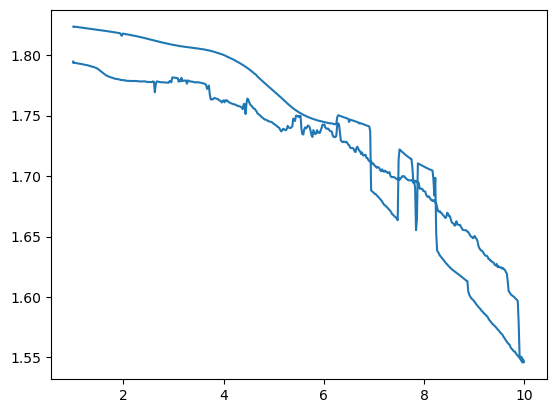

In [17]:
plt.plot(data.V, data.topography)

In [150]:

env.createc_controller.offset_nm = offset_nm
env.createc_controller.im_size_nm= im_size_nm
scan_data1=env.createc_controller.scan_image()

The scan will take 152.0 seconds
offset_test0000 [-177.88882256 -184.61862946]
offset_test1111 [-177.88882256 -184.61862946]
offset_test2222 [-177.88882256 -184.61862946]


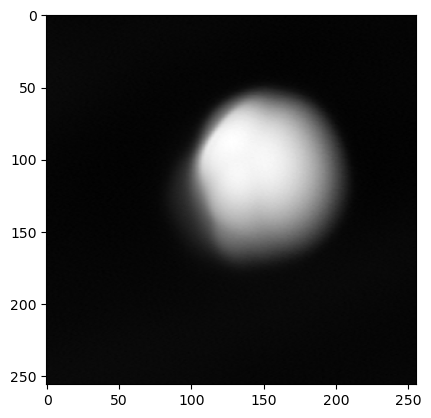

In [151]:
plt.imshow(scan_data1[0])

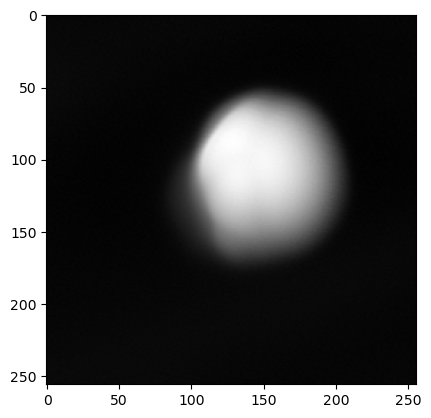

In [145]:
plt.imshow(scan_data1[0])

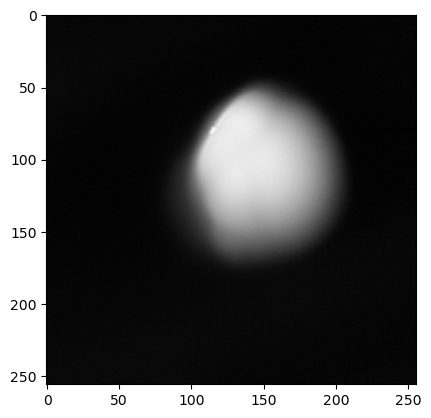

In [137]:
plt.imshow(scan_data1[0])

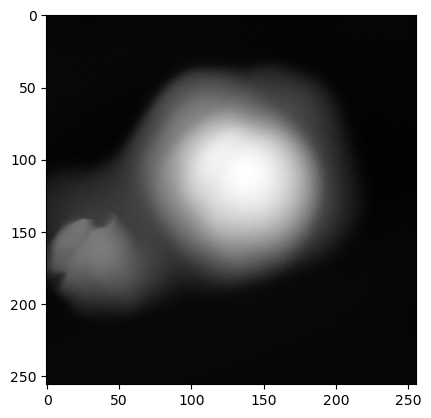

In [118]:
plt.imshow(scan_data1[0])

In [61]:
env.createc_controller.stm.vertsave()

In [125]:
from collections import namedtuple
dissociate_data = namedtuple('dissociate_data',['time','V','Z','current_series','dI_dV','topography'])

time = env.createc_controller.stm.vertdata(0, 0)  # time
V= env.createc_controller.stm.vertdata(1,1)  # voltage
Z = env.createc_controller.stm.vertdata(2,4) # Z
current_series = env.createc_controller.stm.vertdata(3,3) # current series
dI_dV = env.createc_controller.stm.vertdata(4,0) # dI/dV
topography = env.createc_controller.stm.vertdata(15,4)
data = dissociate_data(time,V,Z,current_series, dI_dV, topography)

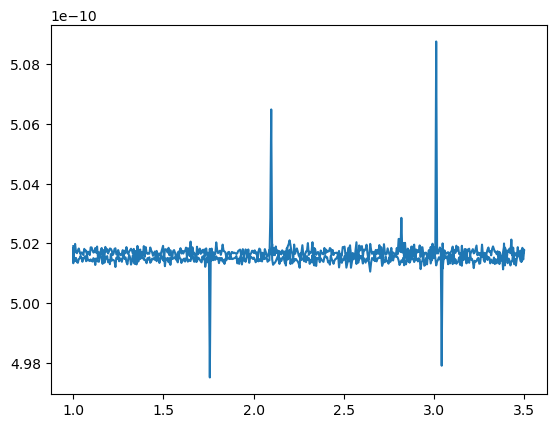

In [133]:
plt.plot(data.V, data.current_series)

In [67]:
env.createc_controller.tip_form(15, -130.224, -202.321)

In [ ]:
-175.507   -195.838   200

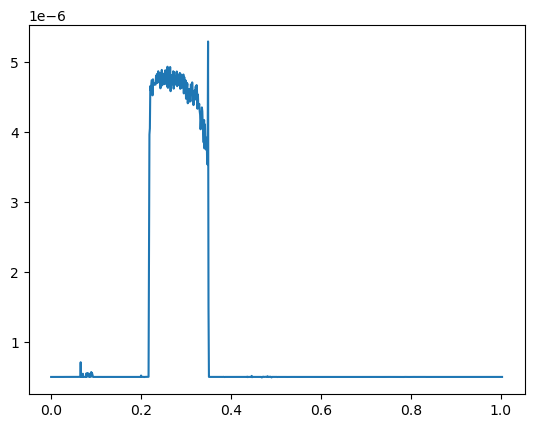

In [60]:
plt.plot(data.time, data.current_series)

In [71]:
env.createc_controller.get_len_nm()

5.9619140625

In [72]:
env.createc_controller.offset_nm = np.array([env.createc_controller.get_offset_nm()[0], env.createc_controller.get_offset_nm()[1]])
env.createc_controller.im_size_nm= env.createc_controller.get_len_nm()
scan_data=env.createc_controller.scan_image()

The scan will take 152.0 seconds
offset_test0000 [-182.46562195 -191.35316467]
offset_test1111 [-182.46562195 -191.35316467]
offset_test2222 [-182.46562195 -191.35316467]


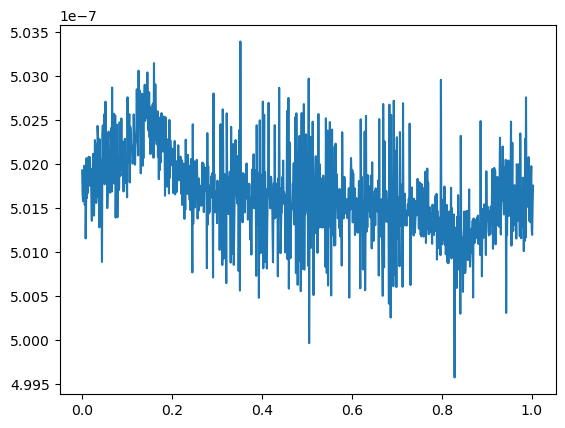

In [56]:
plt.plot(data.time, data.current_series)

In [73]:
offset_nm = np.array([env.createc_controller.get_offset_nm()[0], env.createc_controller.get_offset_nm()[1]])

In [106]:
offset_nm = np.array([env.createc_controller.get_offset_nm()[0], env.createc_controller.get_offset_nm()[1]])
im_size_nm= env.createc_controller.get_len_nm()

In [109]:

data=env.createc_controller.lat_manipulation(-178.916, -182.148, -182.206, -179.681, 32, 1000, offset_nm, im_size_nm)

In [113]:
# env.createc_controller.offset_nm = np.array([env.createc_controller.get_offset_nm()[0], env.createc_controller.get_offset_nm()[1]])
# env.createc_controller.im_size_nm= env.createc_controller.get_len_nm()

env.createc_controller.offset_nm = offset_nm
env.createc_controller.im_size_nm= im_size_nm
scan_data1=env.createc_controller.scan_image()

The scan will take 152.0 seconds
offset_test0000 [-177.88882256 -184.61862946]
offset_test1111 [-177.88882256 -184.61862946]
offset_test2222 [-177.88882256 -184.61862946]


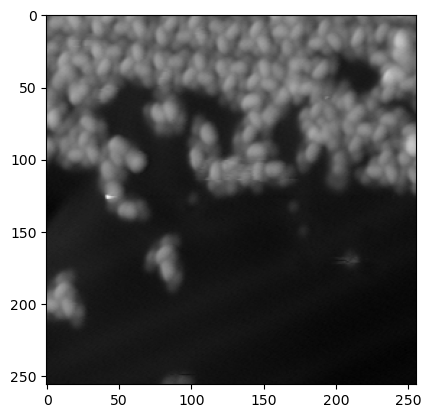

In [103]:
plt.imshow(scan_data[0])

In [ ]:
env.createc_controller.stm.scandata(1,4)

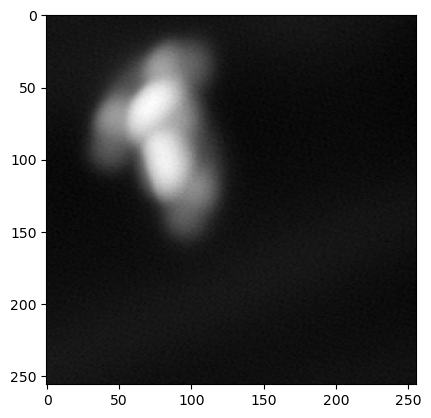

In [112]:
plt.imshow(scan_data1[0])

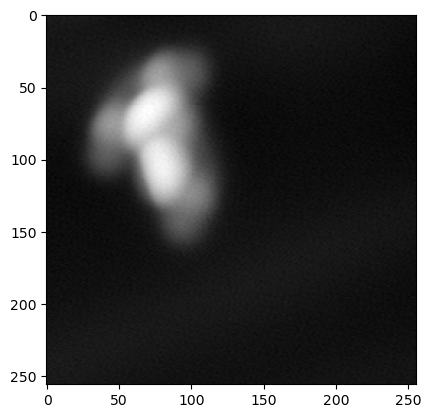

In [105]:
plt.imshow(scan_data1[0])

In [99]:
env.createc_controller.tip_form(15, -107, -250)

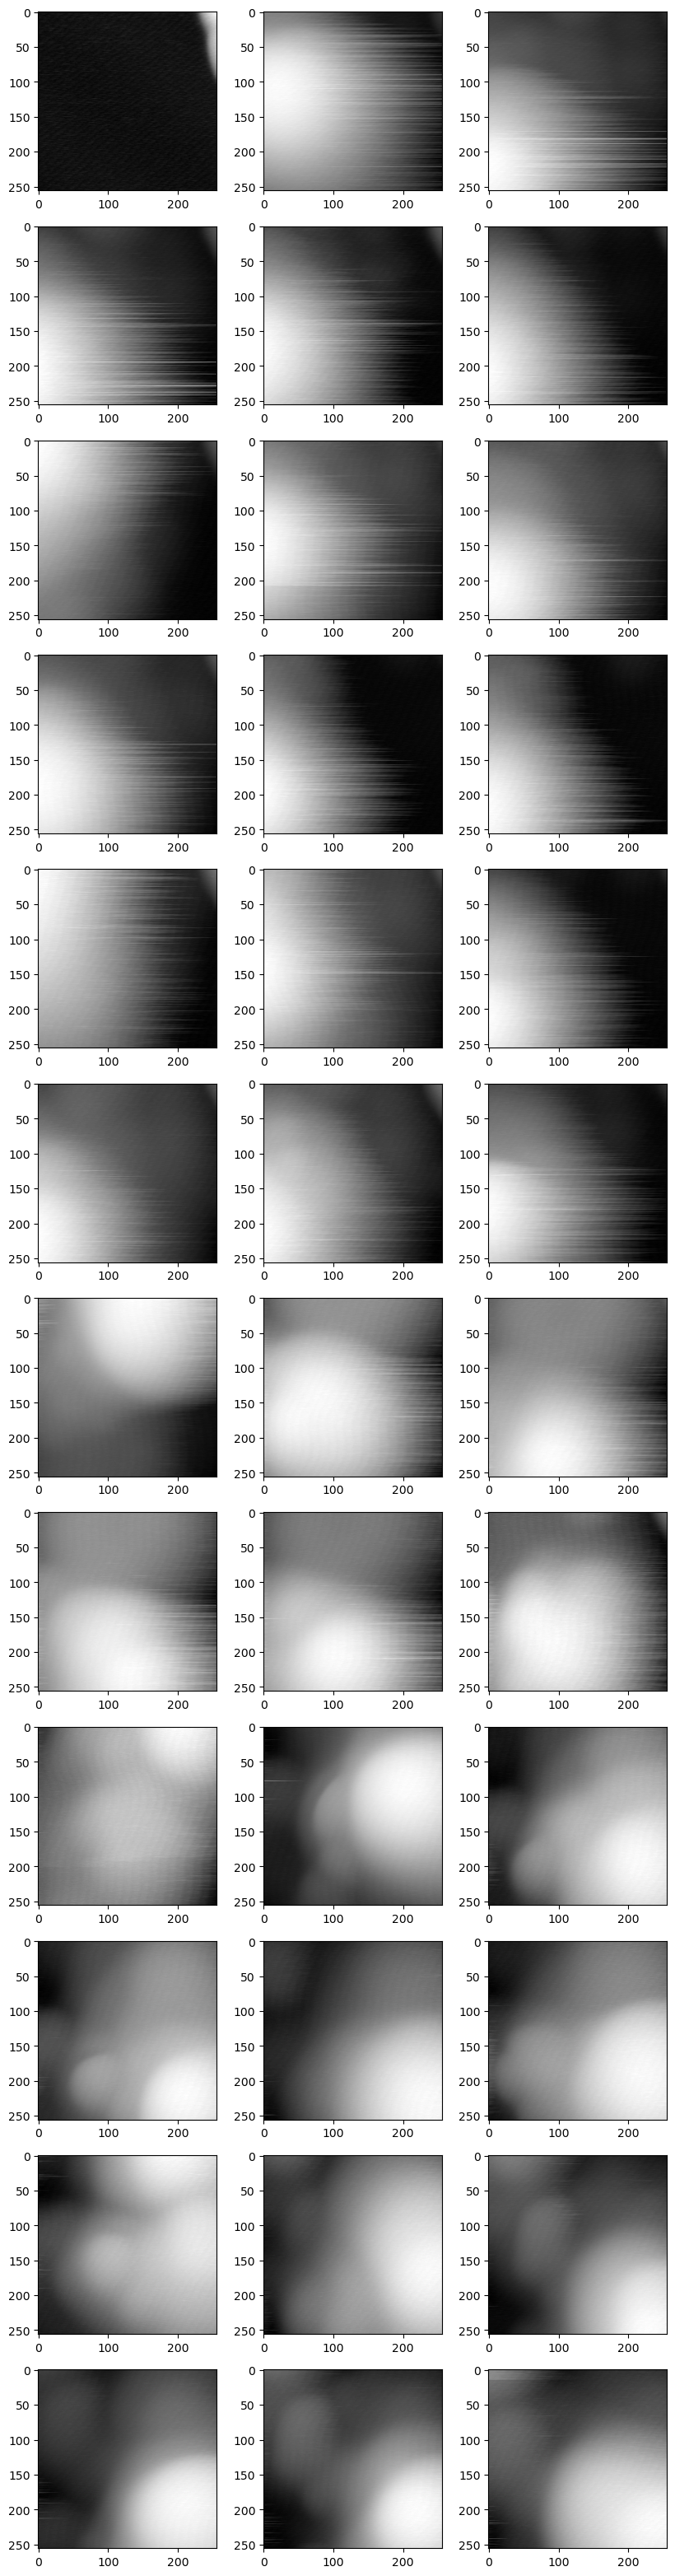

In [28]:
plt.figure(figsize=(10,40))
lens=len(data1_all)
for i in range(lens):
    plt.subplot(12,3,i+1)
    plt.imshow(data1_all[i][0])
    # plt.plot(data_all[i].time, data_all[i].V)

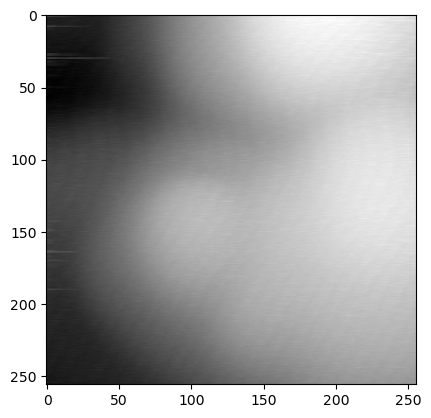

In [14]:
plt.imshow(data1_all[30][0])

# Check lateral manipulation

In [ ]:
mvoltage=10
pcurrent=50000
env.createc_controller.ramp_bias_mV(mvoltage)
preamp_grain = 10**float(env.createc_controller.stm.getparam("Latmangain"))
env.createc_controller.stm.setparam("LatmanVolt",  mvoltage) #(mV)
env.createc_controller.stm.setparam("Latmanlgi", pcurrent*1e-9*preamp_grain) #(pA)
env.createc_controller.stm.latmanip(10, 20, 40, 40)

In [76]:
latmandata = namedtuple('latmandata',['time','x','y','current','dI_dV','topography'])
time = env.createc_controller.stm.latmandata(0, 0)
x= env.createc_controller.stm.latmandata(1,4)
y = env.createc_controller.stm.latmandata(2,4)
current = env.createc_controller.stm.latmandata(3,3)
dI_dV = env.createc_controller.stm.latmandata(4,0)
topography = env.createc_controller.stm.latmandata(15,4)
data = latmandata(time,x,y,current, dI_dV,topography)

In [ ]:
data=env.createc_controller.lat_manipulation(7.45, -15.45, 9.45, -15.45, 32, 1000, np.array([7.13, -16.515]), 10)

In [ ]:
173.549       -233.15
175.176       -224.844

In [ ]:
data=env.createc_controller.lat_manipulation(173.897, -222.015,173.860, -224.087, 32, 1000, np.array([171.39860725, -231.26333809]), 10)

In [ ]:
env.createc_controller.scan_image()

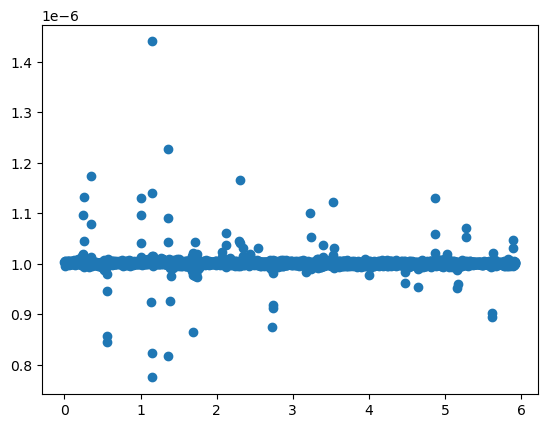

In [77]:
plt.scatter(data.time, data.current)

# Condition probe

In [ ]:
env.createc_controller.stm.setparam('TipForm_Volt', -3) # Set the bias voltage for the atom manipulation(unit V)

env.createc_controller.stm.setparam('TipForm_Z', 0.0) # Set the z position for the atom manipulation(unit angstrom)

env.createc_controller.stm.setparam('Tip_Delay', 0.4915) # Set the delay time for the atom manipulation(unit s)
env.createc_controller.stm.setparam('Tip_Latddx', 833) # Set the lateral ddx for the atom manipulation(unit angstrom/ms^2)
env.createc_controller.stm.setparam('Tip_LatDelay', 20) # Set the lateral delay for the atom manipulation(unit ms)
env.createc_controller.stm.setparam('Tip_Gain', 6) # Set the gain for the atom manipulation(unit 1)
env.createc_controller.stm.setparam('TipForm_Zoffset', 0.0) # Set the z offset for the atom manipulation(unit angstrom)



In [ ]:
tip_condition_actions={'stall': [0, 0],
                      'soft pulse pos':[0, 2.5],
                      'medium pulse pos': [0, 4.0],
                      'soft pulse neg': [0 , -2.5], 
                      'medium pulse neg': [0, -4],
                      'strong pulse neg': [0, -8],
                      'very soft dip': [0, -8],
                      'soft dip 1': [8, 0.02],
                      'soft dip 2': [12, 0.02],
                      'soft dip 3': [16, 0.02],
                      'medium soft': [25, 0.02],
                      'strong dip': [50, 0.02]
                      }

In [ ]:
tip_condition_actions={'stall': [0, 0],
                      'soft pulse pos':[0, 2.5],
                      'medium pulse pos': [0, 4.0],
                      'soft pulse neg': [0 , -2.5], 
                      'medium pulse neg': [0, -4],
                      'strong pulse neg': [0, -8],
                      'very soft dip': [0, -8],
                      'soft dip 1': [-0.80, 0.02],
                      'soft dip 2': [-1.2, 0.02],
                      'soft dip 3': [-1.8, 0.02],
                      'medium soft': [-2.5, 0.02],
                      'strong dip': [-5.0, 0.02]
                      }


In [ ]:
env.createc_controller.stm.scanstop()